In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
import numpy as np 

In [2]:
mnist_dataset = torchvision.datasets.MNIST('./minst', train = True, download=False)

In [3]:
if False:
    it = iter(mnist_dataset)
    img, label = next(it)
    plt.imshow(img);
    plt.show();

In [4]:
tensor_transform = transforms.ToTensor()

dataset = datasets.MNIST(root = "./minst",
                         train = True, download = False,
                         transform = tensor_transform)

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,  # 10GB = 5120,,
                                     shuffle = True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


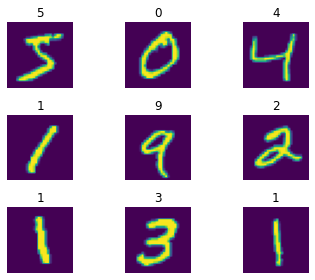

In [5]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols)
for idx in range(rows*cols):
    row = int(idx/cols)
    col = int(idx%cols)
    
    img = dataset[idx][0]*255
    img = img.reshape(28,28).int()
    
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(str(dataset[idx][1]))
    #axs[row, col].suptitle(str(dataset[idx][1]))
    
    plt.tight_layout()
plt.show()

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, (3, 3), padding=1)
        self.act_1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(32, 16, (3, 3), padding=1)
        self.act_2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(16, 8, (3, 3), padding=1)
        self.act_3 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act_1(x)
        x = self.conv2(x)
        x = self.act_2(x)
        x = self.conv3(x)
        x = self.act_3(x)
        # x.shape[0] : 批次數
        x = torch.reshape(x, (x.shape[0], -1))
        return x
    
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dconv1 = torch.nn.ConvTranspose2d(8,16, (3,3), padding=1)
        self.act_1 = torch.nn.ReLU()
        self.dconv2 = torch.nn.ConvTranspose2d(16,32, (3,3), padding=1)
        self.act_2 = torch.nn.ReLU()
        self.dconv3 = torch.nn.ConvTranspose2d(32, 1, (3,3), padding=1)
        self.act_3 = torch.nn.ReLU()
        
    def forward(self, x):
        # (batch, 8=根據Encoder的最後一層 Conv depth, , )
        x = torch.reshape(x, (-1, 8, 28, 28))
        
        x = self.dconv1(x)
        x = self.act_1(x)
        x = self.dconv2(x)
        x = self.act_2(x)
        x = self.dconv3(x)
        x = self.act_3(x)
        
        return x


class NAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [7]:
# test unit 可以做動
hi_encoder = Encoder()

out = hi_encoder(torch.randn((1, 1, 28, 28)))
print(out.shape)

hi_decoder = Decoder()

oout = hi_decoder(out)
print(oout.shape)

hi_autoencoder = NAE()

hi_out = hi_autoencoder(torch.randn((1, 1, 28, 28)))
hi_out.shape


torch.Size([1, 6272])
torch.Size([1, 1, 28, 28])


torch.Size([1, 1, 28, 28])

In [8]:
model = NAE()
model.cuda()
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)

In [9]:
fake_batch = torch.randn((1,1,28,28), device=device)
#model(fake_batch)

C:\Users\lab87\AppData\Local\Temp/ipykernel_2124/3237091686.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, device=device)


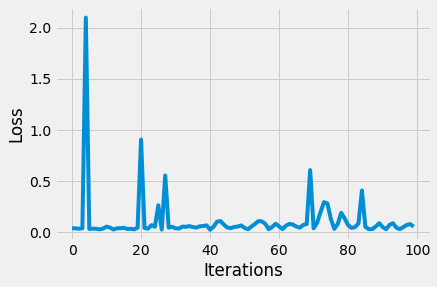

In [10]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
        # Reshaping the image to (-1, 784) , for fully connected bulid,
        # Reshaping the image to (-1(batch size), channel, rows(h), cols(w)) , for CNN bulid.
        image = image.reshape(-1, 1, 28, 28)
        image = image * 255
        image = torch.tensor(image, device=device)
        # Output of Autoencoder
        reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.detach().cpu().numpy())
    outputs.append((epochs, image, reconstructed))
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-100:])

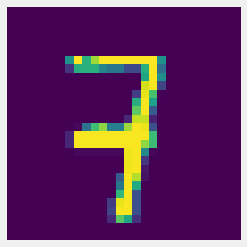

In [25]:
for i, item in enumerate(image):
    
    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28).detach().cpu().numpy()
    plt.axis('off')
    plt.imshow(item[0])
    plt.show()
    break

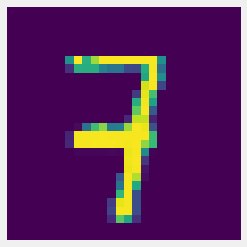

18552.023


In [23]:
for i, item in enumerate(reconstructed):
    
    rebuild = model(item[0].reshape(-1,1,28,28))
    rebuild = rebuild.reshape(-1,28,28).detach().cpu().numpy()
    plt.axis('off')
    plt.imshow(rebuild[0])
    plt.show()
    
    print(rebuild.sum())
    break

In [13]:
encoder = model.encoder
decoder = model.decoder

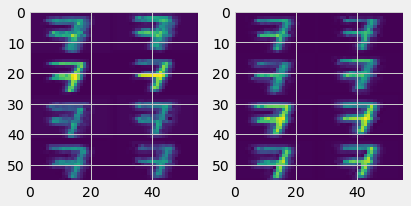

6272

In [45]:
eo = encoder(image[0].reshape(-1,1,28,28))

reo = eo.reshape(2,56,56).detach().cpu().numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(reo[0])
ax[1].imshow(reo[1])

plt.show()
2*56*56

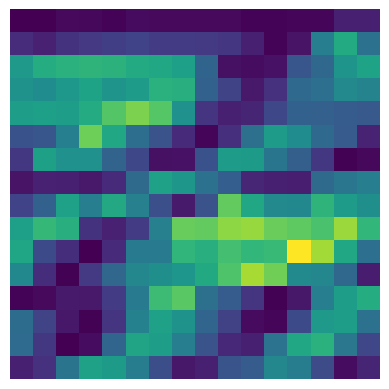

(7, 16, 16)

In [69]:
plt.style.use('default')
vi = np.clip(reo, 0,255)
vi2 = vi[vi>10]
vi2 = vi2.reshape(7,16,16)
plt.axis('off')
plt.imshow(vi2[0])

plt.show()
vi2.shape

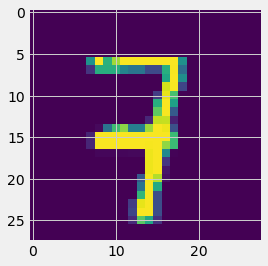

784

In [42]:
plt.imshow(decoder(eo).reshape(28,28).detach().cpu().numpy())
plt.show()
28*28

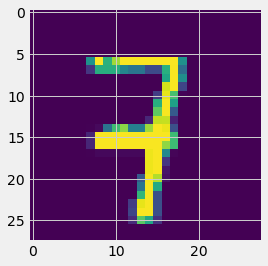

In [16]:
plt.imshow(image[0].detach().cpu().numpy().reshape(28,28))
plt.show()